In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet, Lars
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from scipy.stats import norm
from pysr3.linear.models import LinearL1ModelSR3
from datetime import datetime
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pysindy.utils.odes import lorenz


#### SPY options

In [15]:
calls=pd.read_csv('data/calls.csv')
puts=pd.read_csv('data/puts.csv')
underlying=pd.read_csv('data/underlying_data.csv')

calls.index=calls[calls.columns[0]]
calls=calls.drop(columns=calls.columns[0])

puts.index=puts[puts.columns[0]]
puts=puts.drop(columns=puts.columns[0])

underlying.index=underlying[underlying.columns[0]]
underlying=underlying.drop(columns=underlying.columns[0])

In [16]:
calls['underlying']=underlying['price']
calls.index=[datetime.strptime(i,"%Y-%m-%d") for i in calls.index]
calls['time_to_exp']=[(datetime(2022,9,30)-i).days/365 for i in calls.index]
# calls=calls[calls['time_to_exp']<0.8]
calls=calls.sort_index()[::-1]


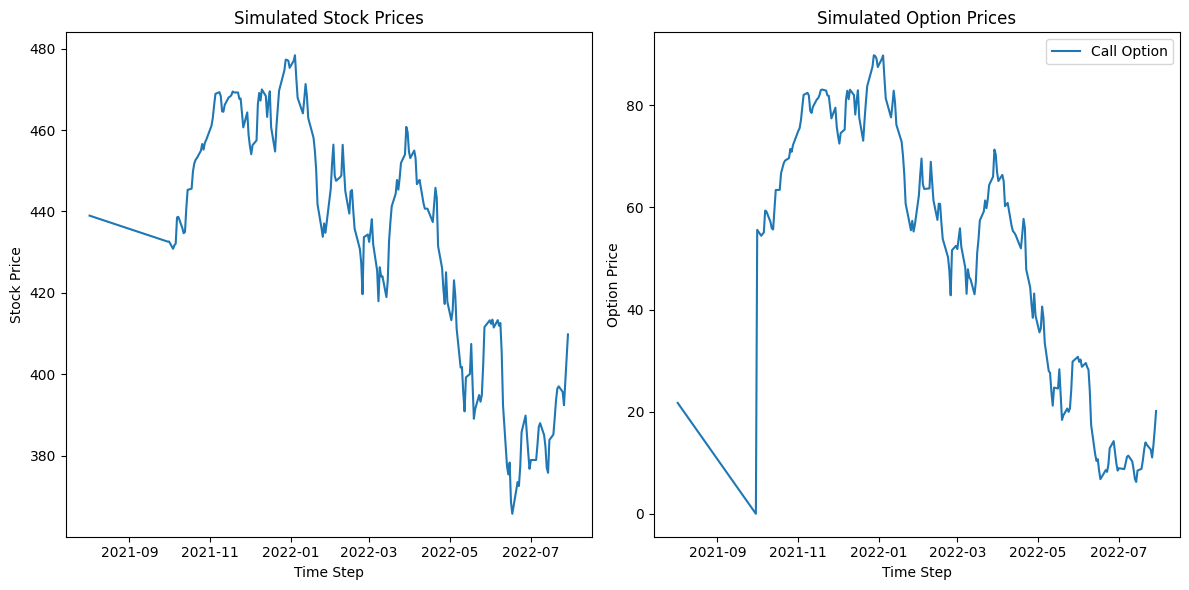

In [17]:
# Plot the simulated stock prices and option prices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(calls['underlying'])
plt.title('Simulated Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')

plt.subplot(1, 2, 2)
plt.plot(calls['price'], label='Call Option')
# plt.plot(option_prices_put, label='Put Option')
plt.title('Simulated Option Prices')
plt.xlabel('Time Step')
plt.ylabel('Option Price')
plt.legend()

plt.tight_layout()
plt.show()

In [85]:
u = np.real(calls['price'])
t = np.ravel(calls['time_to_exp'])
x = np.ravel(calls['underlying'])
# u_dot =  ps.FiniteDifference(axis=0)._differentiate(x= C,t=dt)
# dt = 1
# dt = ps.FiniteDifference(axis=0)._differentiate(x= t,t=1)

### Synthetic Option

In [149]:
# S_t: the spot price of the underlying asset at time t
# r: the risk-free interest rate
# sigma: the volatility of returns of the underlying asset
# K: the strike price or exercise price of the option
# C0: the price of a European call option at time t = 0
# t: current time in years
# T: expiry or maturity date

def black_scholes_call(S, X, T, r, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# lognormal distribution of the price
S0 = 100
r = 0.05  
sigma = 0.25
K = 105

# Monte Carlo simulation
x = np.arange(50,150,0.01)
t = np.arange(0,256,1)
dt = t[1] - t[0]
dx = x[1] - x[0]

X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

u = np.zeros((x.shape[0],t.shape[0]))

for value in range(len(x)):
    for time in range(len(t)):
        S = XT[value,time,0]
        tal = (len(t) - XT[value,time,1])/len(t)
        u[value,time] = black_scholes_call(S,K,tal,r,sigma)


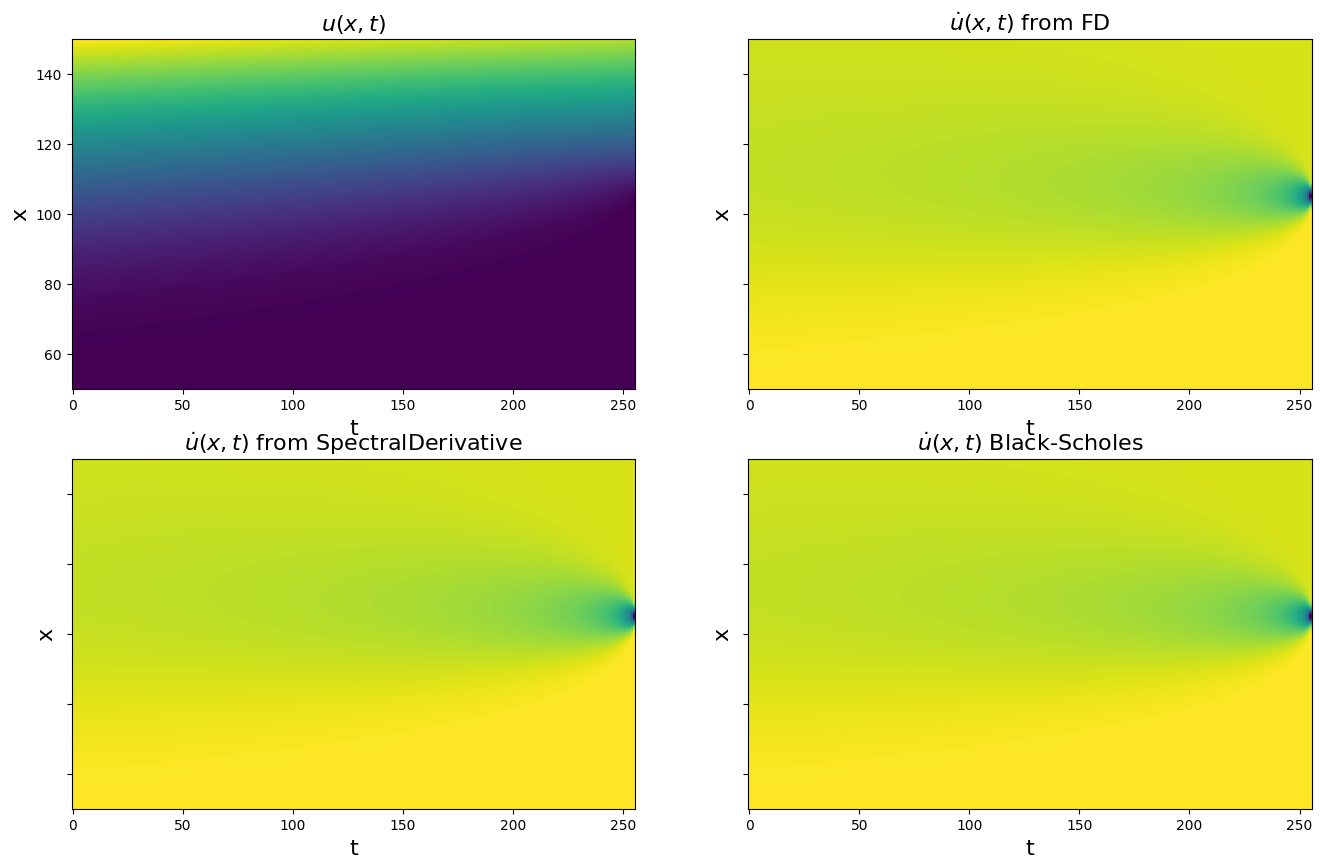

In [150]:
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
# add 20% noise (note the impact on derivatives depends on step size...)
# u = u + np.random.normal(0, rmse / 5.0, u.shape)
spatial_grid = np.array([x]*256).T
spatial_grid = np.reshape(spatial_grid, (len(x),len(t),1))

# Plot u and u_dot
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)

u_dot_ = ps.FiniteDifference(order= 12,axis=1, is_uniform  = True)._differentiate(u, t=dt)
plt.subplot(2, 2, 2)
plt.pcolormesh(t, x, u_dot_)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from FD", fontsize=16)

u_dot_spc = ps.SpectralDerivative(axis=1)._differentiate(u, t=dt)
plt.subplot(2, 2, 3)
plt.pcolormesh(t, x, u_dot_)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from SpectralDerivative", fontsize=16)

u_x = ps.FiniteDifference(axis=0)._differentiate(u,t = dx)
u_xx = ps.FiniteDifference(axis=0)._differentiate(u_x,t = dx)
u_dot = -1/2*(sigma**2)*u_xx*(spatial_grid[:,:,0]**2) - r*spatial_grid[:,:,0]*u_x + r*u
plt.subplot(2, 2, 4)
plt.pcolormesh(t, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ Black-Scholes", fontsize=16)
plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

In [151]:
#Diff betwen numerical integration and Black-and-Scholes 
np.linalg.norm(u_dot - u_dot_)

11308.35286706687

In [148]:
u_dot_

array([[-3.33708927e-04, -3.28570557e-04, -3.23469700e-04, ...,
        -2.37126525e-44, -9.45587811e-46,  9.30449067e-43],
       [-4.19428445e-04, -4.13342927e-04, -4.07296224e-04, ...,
        -2.39294684e-42, -9.98615713e-44,  9.39220548e-41],
       [-5.21699592e-04, -5.14572840e-04, -5.07485254e-04, ...,
        -1.96051158e-40, -8.68509286e-42,  7.69790911e-39],
       ...,
       [-2.50824599e-02, -2.50831863e-02, -2.50838044e-02, ...,
        -2.04957997e-02, -2.04998032e-02, -2.05038075e-02],
       [-2.48873860e-02, -2.48873932e-02, -2.48872909e-02, ...,
        -2.04957997e-02, -2.04998032e-02, -2.05038075e-02],
       [-2.46961933e-02, -2.46955295e-02, -2.46947554e-02, ...,
        -2.04957997e-02, -2.04998032e-02, -2.05038075e-02]])

In [144]:
u_dot

array([[-9.65653256e-002, -9.51388455e-002, -9.37218499e-002, ...,
         1.12994552e-140,  3.17737705e-210,  0.00000000e+000],
       [-1.12246515e-001, -1.10646949e-001, -1.09057192e-001, ...,
        -1.17559545e-140, -3.30574308e-210,  0.00000000e+000],
       [-1.34458878e-001, -1.32632783e-001, -1.30816632e-001, ...,
        -3.82481263e-133, -5.86977084e-199,  0.00000000e+000],
       ...,
       [-6.42235764e+000, -6.42254932e+000, -6.42271333e+000, ...,
        -5.24692473e+000, -5.24794962e+000, -5.24897471e+000],
       [-6.39486412e+000, -6.39489759e+000, -6.39490291e+000, ...,
        -5.24692473e+000, -5.24794962e+000, -5.24897471e+000],
       [-6.39014256e+000, -6.39004956e+000, -6.38992784e+000, ...,
        -5.24692473e+000, -5.24794962e+000, -5.24897471e+000]])

In [146]:
u[0][0] 

0.01487763020834984

In [147]:
u[0][1]

0.014546493582991898

### PySINDy

In [161]:
u = np.reshape(u, (len(x), len(t), 1))
u_dot  = np.reshape(u_dot, (len(x), len(t), 1))
u_dot_ = np.reshape(u_dot_, (len(x), len(t), 1))

library_functions = [lambda x: x]
library_function_names = [lambda x: x]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_interaction = False,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
)

u_final = pde_lib.fit_transform(u)
u_final = np.concatenate((u_final,spatial_grid,spatial_grid**2),axis=2)
dic_var = {'x0':'u','x1':'u_x', 'x2':'u_xx','x3':'x','x4':'x^2'}
library_functions = [lambda x: x,lambda x,y: x*y]
library_function_names = [lambda x: dic_var[x],lambda x,y: dic_var[x] + '*' + dic_var[y]]
lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=True
)

In [ ]:

# Fit and predict with the non-weak model
print('SR3 Regression')

opt = ps.SR3(
    threshold=8, thresholder="l1", tol=1e-12, normalize_columns=True, max_iter=1000000
)
model_for_prediction = ps.SINDy(feature_library=lib, optimizer=opt)
model_for_prediction.fit(u_final,x_dot = u_dot)
# print(model_for_prediction.score(u_test))
# Prints a very wrong model
model_for_prediction.print()

In [159]:
print('STLSQ Regression')
optimizer = ps.STLSQ(threshold=8, alpha=1e-12, normalize_columns=True)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final,x_dot = u_dot)
# print(model.score(u_test))
model.print()

STLSQ Regression
(x0)' = 0.050 u + -0.050 u_x*x + -0.031 u_xx*x^2


In [185]:
spatial_grid = np.reshape(x, (len(x),1))

# Define weak form PDE library
library_functions = [lambda x: x]
library_function_names = [lambda x: x]

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=False,
    include_interaction = False,
    K=10000,
)

u_final = pde_lib.fit_transform(u)
u_final = np.concatenate((u_final,spatial_grid,spatial_grid**2),axis=1)
dic_var = {'x0':'u','x1':'u_x', 'x2':'u_xx','x3':'x','x4':'x^2'}
library_functions = [lambda x: x,lambda x,y: x*y]
library_function_names = [lambda x: dic_var[x],lambda x,y: dic_var[x] + '*' + dic_var[y]]
lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=True
)

print('SR3 Regression')
# Fit a weak form model
optimizer = ps.SR3(
    threshold=.1, thresholder="l1", tol=1e-8, normalize_columns=True, max_iter=1000
)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u,x_dot =u_dot , quiet=True)
print(model.score(u))
model.print()

print('STLSQ Regression')
optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u,x_dot = u_dot , quiet=True)
print(model.score(u))
model.print()

SR3 Regression
-109466.03964275101
(x0)' = -4.240 1 + -0.101 u
STLSQ Regression
-109466.03964275101
(x0)' = -4.240 1 + -0.101 u
